In [1]:
# Author: Antti Kiviaho
# Date: 10.5.2023

import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from scripts.utils import load_from_pickle
from scipy.stats import chisquare
from datetime import datetime
import igraph as ig

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


## Function definitions

In [53]:
def score_modules(ctype, genes_dict):
    dat = sc.read_h5ad('nmf_annotation/'+ ctype + '.h5ad')
    dat.X = dat.layers['counts'].copy()

    for k in genes_dict.keys():
        lst = genes_dict[k]

        # Score the gene expression data.
        sc.tl.score_genes(dat, gene_list=lst, score_name=k)

    # Find the column with the highest score and add a new column for the corresponding module.
    score_cols = list(genes_dict.keys())
    max_col = dat.obs[score_cols].idxmax(axis=1)
    dat.obs['max_scoring'] = max_col

    obs_with_scores = dat.obs.copy()
    del dat

    return(obs_with_scores)


def calculate_phenotype_distributions(df,module):

    # Phenotype proportions in the celltype as a whole
    bground_proportions = df['phenotype'].value_counts()/len(df)
    order = bground_proportions.index

    # The number of cells scoring highest on this module
    subset = df[df['max_scoring'] == module]
    # Expected proportions based on the celltype proportions
    expected = bground_proportions*len(subset)

    observed = subset['phenotype'].value_counts()[order]

    contig_table = pd.DataFrame({'expected':expected.astype(int),
    'observed':observed,
    'diff':observed-expected.astype(int)})

    pval = chisquare(observed,expected).pvalue

    print(module+': top scoring in ' + str(len(subset))+' cells')
    print(contig_table)
    print('chi2 test p-value: ' + str(pval))
    print('')

    
def plot_score_violins(scores_df):
    # Take all columns with module in their name
    module_columns = [col for col in scores_df.columns if 'module' in col]
    module_columns.append('max_scoring')

    if len(module_columns) > 0:
        violin_df = scores_df[module_columns]

        rows = len(module_columns)//2
        fig, axs = plt.subplots(rows, 2, figsize=(15, 5 * rows))

        for i in range(len(module_columns)-1): # Don't plot the last column
            row = i // 2
            col = i % 2
            
            sns.violinplot(data=violin_df, x='max_scoring', y=module_columns[i], ax=axs[row][col])
            axs[row][col].tick_params(axis='x', rotation=30)

            # Get the 1st quantile of highest scoring module
            val_80 = violin_df.loc[violin_df['max_scoring'] == module_columns[i],module_columns[i]].quantile(q=0.25)

            # Add horizontal line
            axs[row][col].axhline(y=val_80, color='black', linestyle='--')

        
        plt.show()
    else:
        print("No columns found with 'module' in their names.")


def save_dict_to_excel(dict_with_modules,ctype):
    # Saves the factors to a dataframe and onto an excel sheet
    max_length = max(len(lst) for lst in dict_with_modules.values())
    for key in dict_with_modules:
        dict_with_modules[key].extend([np.nan]*(max_length - len(dict_with_modules[key])))

    df_with_modules = pd.DataFrame.from_dict(dict_with_modules)
    df_with_modules.to_excel(ctype+'_modules_'+datetime.today().strftime('%Y%m%d')+'.xlsx')
    

def create_modules_from_adjacency_matrix(celltype,min_modules_per_connection=5,
                                         min_connections_per_gene=5,min_genes_in_module=10,
                                         plot_clustermap=True):
    '''
    This is a function that takes an adjacency matrix of gene connections as 
    input and generates clusters of genes using the Leiden algorithm implemented 
    in the python module igraph. The clusters are then filtered and returned in the
    form of a dictionary with keys as module indexes and values as lists of gene
    names. The function includes a number of default arguments, such as minimum
    number of modules per connection (5), minimum number of connections per gene (5),
    minimum number of genes in a module (10), and a boolean flag to indicate whether
    to plot a clustermap using seaborn (True). The function works by filtering the 
    adjacency matrix to remove weak connections, then using the igraph module to group
    the genes in clusters. The clusters are filtered for minimum size and sorted by size.
    The resulting gene modules are returned as a dictionary, and a seaborn clustermap is
    plotted if desired.
    '''
    adj_df = pd.read_csv('nmf_annotation/'+celltype+'_nmf_derived_gene_adjacencies.csv',index_col=0)

    # Filter connections occurring in fewer than 5 modules
    adj_df[adj_df<=min_modules_per_connection] = 0

    # Filter genes with less than 5 connections
    adj_df = adj_df[adj_df.astype(bool).sum(axis=1) >= min_connections_per_gene]

    # Filter the columns as well
    adj_df = adj_df[adj_df.index] 

    # create graph object
    g = ig.Graph.Adjacency(np.matrix(adj_df),mode='undirected')

    # find clusters
    clusters = g.community_leiden()

    # Extract cluster labels and link them to genes (index)
    labels = pd.Series(clusters.membership)
    labels.index = adj_df.index.copy()

    # Filter the modules by minimum number of genes present and sort them by the number of genes 
    labels_to_keep = list(labels.value_counts()[pd.Series(labels).value_counts() >= min_genes_in_module].index)



    # Save the genes of each module (cluster) to a dictionary
    modules = {}
    for idx,l in enumerate(labels_to_keep):
        modules['module'+str(idx)] = list(adj_df[labels == l].index)

    adj_df = adj_df[[value for key in modules for value in modules[key]]]
    adj_df = adj_df.loc[[value for key in modules for value in modules[key]]]

    if plot_clustermap:
        sns.clustermap(adj_df, cmap='magma', figsize=(6,6),row_cluster=False,col_cluster=False,
                       vmax=np.quantile(np.matrix(adj_df),0.99))


    # Return the dictionary
    return(modules, adj_df)



## Annotating immune cells

In [3]:
# Formatting the immune cells into anndata for celltypist

import anndata as ad

dat = sc.read_h5ad('aggregate_sc_data_with_broad_annotation_20230613.h5ad')

dat = dat[dat.obs['refined_celltypes'].isin(['T cell','Myeloid','Plasma','Dendritic','B cell','Mast'])]
dat_immune_raw = ad.AnnData(X = dat.layers['counts'],var=dat.var,obs = dat.obs)
sc.pp.normalize_total(dat_immune_raw,target_sum=1e4)
sc.pp.log1p(dat_immune_raw)
dat_immune_raw.write('immune_cells_for_celltypist_20230619.h5ad')

Ran celltypist using the web interface: https://www.celltypist.org/ (accessed 19.6.2023)

In [4]:
## Downloading the celltypist results
immune_cell_data = sc.read_h5ad('celltypist/immune_cells_for_celltypist_20230619.h5ad')
celltypist_predictions = pd.read_csv('celltypist/predicted_labels.csv',index_col=0)
if (immune_cell_data.obs_names == celltypist_predictions.index).all():
    merged_obs = pd.merge(immune_cell_data.obs,celltypist_predictions,left_index=True,right_index=True)
    immune_cell_data.obs = merged_obs

In [5]:
# Filter the different immune cell subtypes by a minimum cell count threshold
# Setting the number of minimum cells to keep at 1000
immune_cells_to_keep = list(immune_cell_data.obs['predicted_labels'].value_counts()[:24].index)

# Print to see how consistently the celltypist annotated celltypes are from a single broad celltype
for type in immune_cells_to_keep:
    print(type)
    vals = immune_cell_data.obs[immune_cell_data.obs['predicted_labels'] == type]['refined_celltypes'].value_counts().values
    print("{:.2%}".format(vals[0]/np.sum(vals)))
    print('')

# Subset the data
immune_cell_data = immune_cell_data[immune_cell_data.obs['predicted_labels'].isin(immune_cells_to_keep)]

Trm cytotoxic T cells
99.37%

Tem/Trm cytotoxic T cells
99.02%

Tem/Effector helper T cells
99.37%

Regulatory T cells
97.71%

Mast cells
99.04%

Macrophages
99.70%

Memory B cells
98.10%

Type 1 helper T cells
96.95%

B cells
94.62%

Type 17 helper T cells
99.35%

Tcm/Naive helper T cells
98.06%

CD16+ NK cells
97.48%

CD16- NK cells
98.18%

DC2
99.49%

DC
98.90%

Classical monocytes
98.53%

Tem/Temra cytotoxic T cells
97.24%

Follicular helper T cells
97.69%

Naive B cells
91.14%

Non-classical monocytes
99.05%

Plasma cells
93.33%

NK cells
95.90%

Monocytes
98.46%

Tcm/Naive cytotoxic T cells
95.56%



In [56]:
# Create a dataframe for final annotations of all cells
final_annotations = pd.DataFrame()

In [ ]:
final_annotations = pd.concat([final_annotations,immune_cell_data.obs['predicted_labels']],axis=0)

## Revising the NMF strategy

The full list of modules obtained for individual tumors was filtered to retain only those with at least 5% overlap (by Jaccard index) with at least two other modules. An adjacency matrix was then constructed connecting genes according to the number of individual tumor modules in which they co-occur. Gene–gene connections were filtered out if they occurred in fewer than two individual tumor modules, and genes with fewer than three connections were removed. The graph was clustered using infomap clustering implemented in the igraph package v.1.2.11 (ref. 93). Finally, modules with potential biological relevance were retained by filtering out those with fewer than five genes or without significant overlap with gene ontology terms. The final graph (Extended Data Fig. 3f) was visualized with the Fruchterman–Reingold layout.

- Methods from Barkley et al. Nat. Genetics 2022

## Loading the NMF gene lists and scoring them

### Epithelial

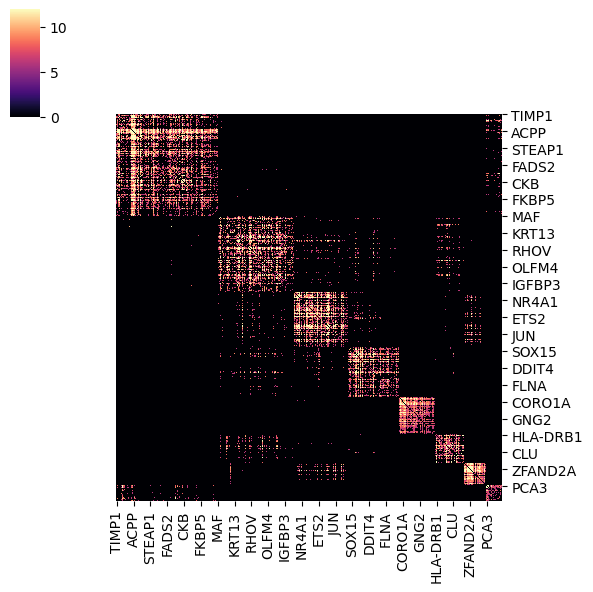

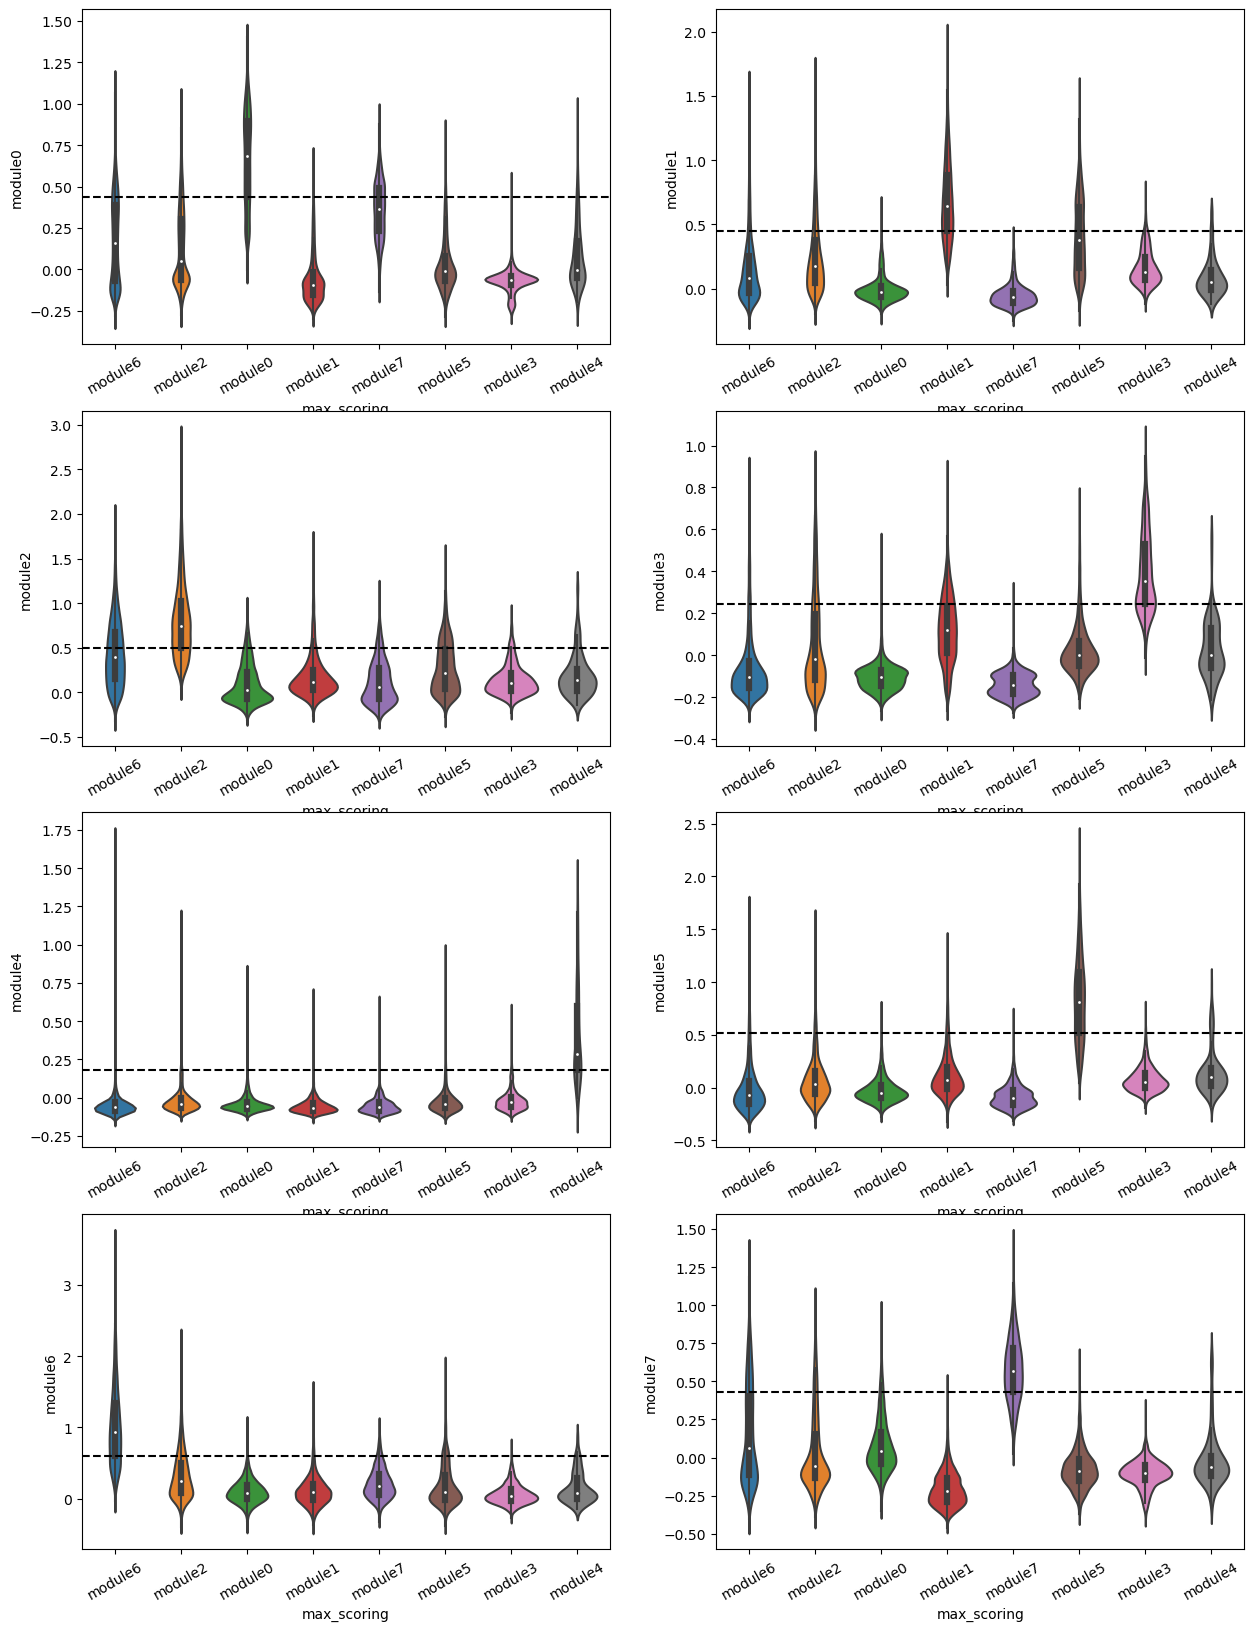

In [54]:
modules_dict, adjacency_df = create_modules_from_adjacency_matrix('Epithelial')
scores = score_modules('Epithelial',modules_dict)


plot_score_violins(scores)
save_dict_to_excel(modules_dict,'Epithelial')

In [58]:
# Rename the columns accordingly
replacements = {'module0':'luminal epithelium','module1':'EMT epithelium',
                'module2':'stress signaling epithelium','module3':'basal epithelium',
                'module4':'immune response epithelium','module5':'interferon signaling epithelium',
                'module6':'chaperone response epithelium','module7':'cancer epithelium'
}


for k in list(replacements.keys()):
    scores['max_scoring'] = scores['max_scoring'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,scores['max_scoring']],axis=0)

### Fibroblast_muscle

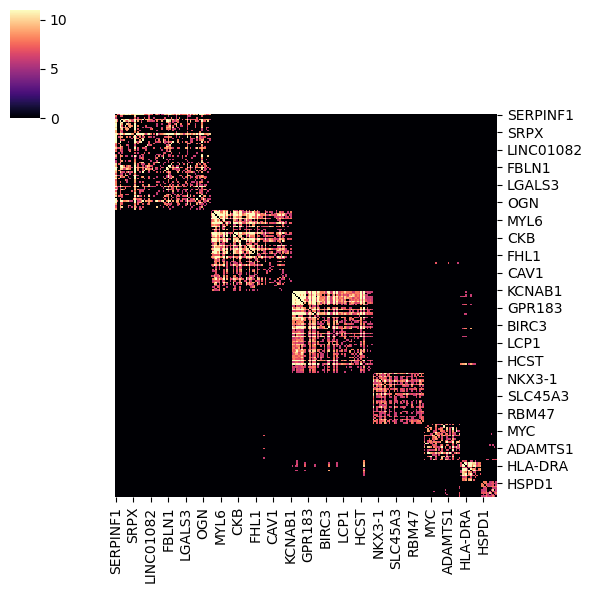

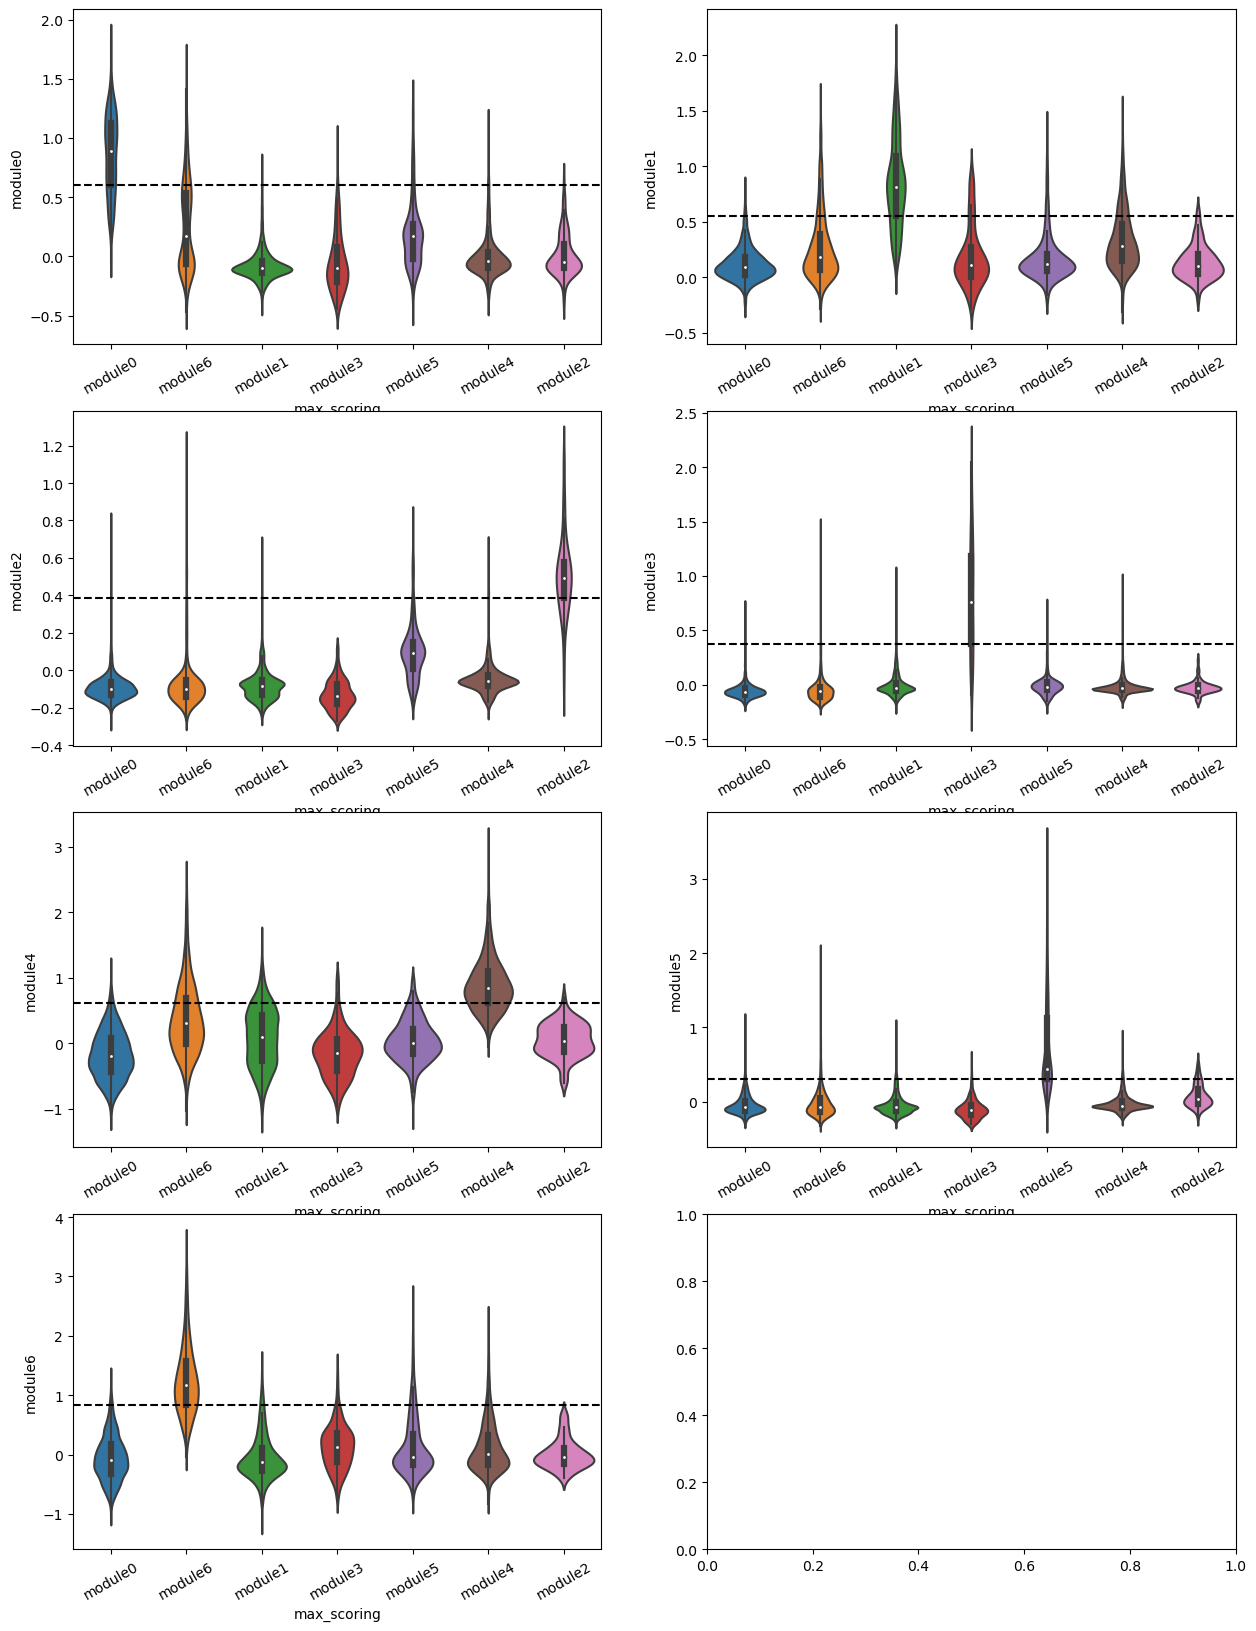

In [60]:
modules_dict,adjacency_df = create_modules_from_adjacency_matrix('Fibroblast_muscle')
scores = score_modules('Fibroblast_muscle',modules_dict)

plot_score_violins(scores)
save_dict_to_excel(modules_dict,'Fibroblast_muscle')

In [61]:
for module in list(modules_dict.keys()):
    calculate_phenotype_distributions(scores,module)

module0: top scoring in 4819 cells
        expected  observed  diff
PCa         2307      1577  -730
normal      1672      2427   755
CRPC         839       815   -24
chi2 test p-value: 4.570555047721553e-125

module1: top scoring in 6919 cells
        expected  observed  diff
PCa         3313      3984   671
normal      2401      1945  -456
CRPC        1204       990  -214
chi2 test p-value: 2.3874097550326247e-57

module2: top scoring in 122 cells
        expected  observed  diff
PCa           58        55    -3
normal        42        59    17
CRPC          21         8   -13
chi2 test p-value: 0.0005486172368368123

module3: top scoring in 265 cells
        expected  observed  diff
PCa          126       156    30
normal        91        55   -36
CRPC          46        54     8
chi2 test p-value: 1.0825929250770482e-05

module4: top scoring in 4201 cells
        expected  observed  diff
PCa         2011      2159   148
normal      1457      1993   536
CRPC         731        49  -

In [62]:
# Rename the columns accordingly
replacements = {'module0':'inflammatory fibroblasts','module1':'myofibroblasts',
                'module2':'immune response fibroblasts','module3':'luminal-like fibroblasts',
                'module4':'stress response fibroblasts','module5':'interferon signaling fibroblasts',
                'module6':'chaperone response fibroblasts'
}


for k in list(replacements.keys()):
    scores['max_scoring'] = scores['max_scoring'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,scores['max_scoring']],axis=0)

### Endothelial

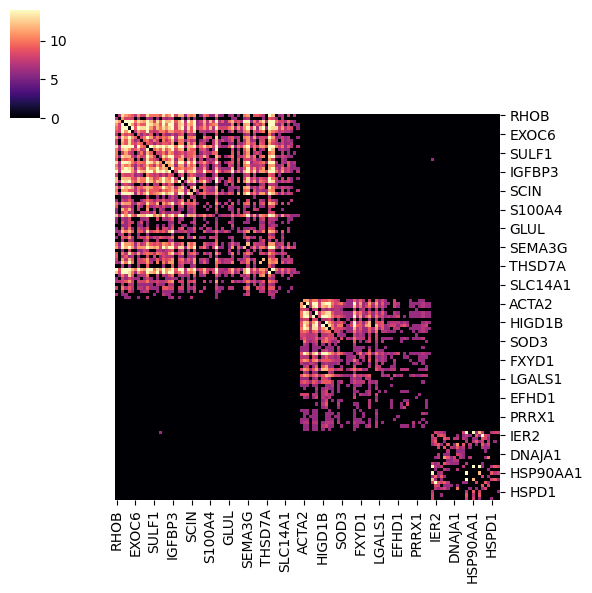

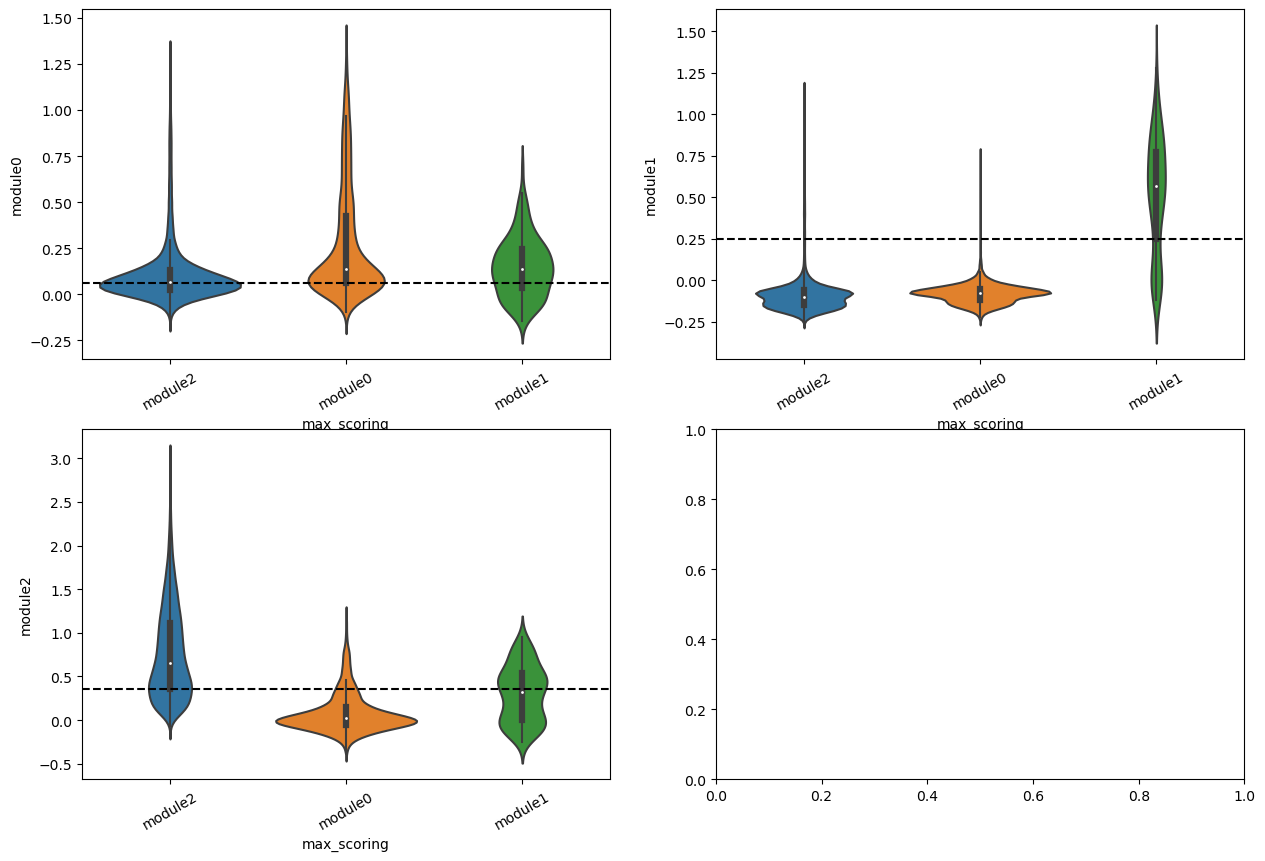

In [63]:
modules_dict, adjacency_df = create_modules_from_adjacency_matrix('Endothelial')
scores = score_modules('Endothelial',modules_dict)

# remove the first quantile of scores to ensure a representative set
#max_factor_scores = scores[list(modules_dict.keys())].max(axis=1)
#fitered_scores = scores[max_factor_scores > np.quantile(max_factor_scores,0.25)]

plot_score_violins(scores)
save_dict_to_excel(modules_dict,'Endothelial')

In [64]:
for module in list(modules_dict.keys()):
    calculate_phenotype_distributions(scores,module)

module0: top scoring in 3201 cells
        expected  observed  diff
PCa         2043      2311   268
normal       976       813  -163
CRPC         181        77  -104
chi2 test p-value: 2.2871907931267657e-27

module1: top scoring in 141 cells
        expected  observed  diff
PCa           89       116    27
normal        43        18   -25
CRPC           8         7    -1
chi2 test p-value: 1.5319730222351753e-05

module2: top scoring in 19408 cells
        expected  observed  diff
PCa        12387     12094  -293
normal      5918      6107   189
CRPC        1101      1207   106
chi2 test p-value: 9.688546556325535e-06



In [65]:
# Rename the columns accordingly
replacements = {'module0':'common endothelium','module1':'mesenchymal endothelium',
                'module2':'stress response endothelium'
}


for k in list(replacements.keys()):
    scores['max_scoring'] = scores['max_scoring'].replace(k, replacements[k])

final_annotations = pd.concat([final_annotations,scores['max_scoring']],axis=0)

## Merging annotations with data

In [26]:
final_annotations = final_annotations.rename(columns={0:'final_annotation'})

In [36]:
adata = sc.read_h5ad('aggregate_sc_data_with_broad_annotation_20230613.h5ad')
adata.X = adata.layers['counts'].copy()
del adata.layers['counts']

In [37]:
adata.obs

,sample,patient,celltype_orig,phenotype,dataset,total_counts,n_counts,n_genes,VI_clusters,refined_celltypes
GSM4089152_P2_AACTCTTAGCAGATCG.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3392.493240,17119.0,3614,3,Myeloid
GSM4089152_P2_AACTTTCTCCTCGCAT.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3340.923136,13449.0,3213,3,Myeloid
GSM4089152_P2_AATCCAGGTTGCTCCT.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3231.120522,13044.0,3254,3,Myeloid
GSM4089152_P2_ACCAGTATCGTTTATC.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3251.162930,12199.0,3143,3,Myeloid
GSM4089152_P2_ACGAGCCCACGAAGCA.1,GSM4089152_P2,GSM4089152_P2,Myeloid,CRPC,dong_2020,3108.356698,8338.0,2373,3,Myeloid
...,...,...,...,...,...,...,...,...,...,...
SCG-PCA22-T-HG_TTTGTCAGTGGGTCAA-1,hirz_PCA22_T,hirz_PCA22,Naive Th,PCa,hirz_2023,1005.024504,3349.0,871,4,T cell
SCG-PCA22-T-HG_TTTGTCAGTGGTTTCA-1,hirz_PCA22_T,hirz_PCA22,B cells,PCa,hirz_2023,956.916235,1996.0,688,7,B cell
SCG-PCA22-T-HG_TTTGTCAGTTAAAGAC-1,hirz_PCA22_T,hirz_PCA22,Mast cells,PCa,hirz_2023,988.562933,2639.0,861,11,Mast
SCG-PCA22-T-HG_TTTGTCAGTTTAGCTG-1,hirz_PCA22_T,hirz_PCA22,CTL-2,PCa,hirz_2023,977.683187,2391.0,978,4,T cell


In [38]:
merged_df = pd.merge(adata.obs, final_annotations, left_index=True, right_index=True, how='left')
#merged_df['final_annotation'] = merged_df['final_annotation'].fillna(merged_df['refined_celltypes'])

if (merged_df.index == adata.obs.index).all():
    adata.obs = merged_df.copy()
    print('Done')



Done


In [39]:
# Removing the cells with nan as cell type reference
adata = adata[~adata.obs['final_annotation'].isna()]

# Removing factors that were top scorers in less than 100 cells
adata = adata[~(adata.obs['final_annotation']=='drop')]

# Removing cells that scored under the 1st quantile (have their original broad annotation)
#adata = adata[~(adata.obs['final_annotation']=='T cell')] # It's named T_cell in the dictionary


#for k in list(nmf_components_by_ctype.keys()):
#    adata = adata[~(adata.obs['final_annotation']==k)]

In [40]:
# Finished, annotated data
print(adata.obs['final_annotation'].value_counts())
print('')
print('The total number of different celltypes: ' + str(len(adata.obs['final_annotation'].unique())))

Trm cytotoxic T cells               34071
luminal epithelium                  21851
EMT epithelium                      20071
Tem/Trm cytotoxic T cells           17677
stress response endothelium         17645
chaperone response epithelium       15328
Tem/Effector helper T cells         14385
stress signaling epithelium         13862
Regulatory T cells                  13391
Mast cells                           9227
Macrophages                          8865
myofibroblasts                       6916
Memory B cells                       6574
cancer epithelium                    5475
Type 1 helper T cells                5377
B cells                              4910
common endothelium                   4847
inflammatory fibroblasts             4819
Type 17 helper T cells               4612
stress response fibroblasts          4201
chaperone response fibroblasts       4037
interferon signaling epithelium      3949
Tcm/Naive helper T cells             3599
CD16+ NK cells                    

In [41]:
adata.write('./single_cell_reference_with_nmf_derived_annotations_20230621.h5ad')